# MNIST extended: a simple dataset for semantic segmentation and object detection

Most open source datasets for computer vision are huge and complex. Building a model from scratch using ImageNet or Coco is impossible without days of training on specialised hardware such as GPUs or TPUs. I've often found myself in need of a simple and small dataset to test model architectures. I don't always have a GPU available and I don't want to wait hours for the results of my experiments.
For image classification I often use MNIST. It's an incredibly useful dataset of small digts (if you're not familiar with it don't worry, we'll see what it looks like soon.). However, in its raw form it's really only useful for image classification tasks. For more complex tasks such as semantic segmentation and object detection I created MNIST extended, a dataset as simple as MNIST but that can be used for more than just image classification. In this post, I will describe how to use MNIST extended and share a few details on the simple code that is used to generate it.

This dataset is used in my ["Simple deep learning" series](https://awaywithideas.com/simple-deep-learning) in the following posts:
- [A simple example of semantic segmentation with tensorflow keras](https://awaywithideas.com/a-simple-example-of-semantic-segmentation-with-tensorflow-keras)

This post won't go into the details of how the dataset is created, rather we'll focus on what the dataset is composed of. However, the code is very well documented and easy to understand. You can find all the functions used here in my [MNIST extended package](https://github.com/LukeTonin/simple-deep-learning/tree/main/simple_deep_learning/mnist_extended) on github.

## MNIST

MNIST is a dataset of handwritten digits.
The original dataset can be downloaded from [Yann Lecun's website](http://yann.lecun.com/exdb/mnist/).
However, we do not need to download the data from there since we will be using a Keras function to do that for us. This dataset forms the base of both the semantic
segmentation and object detection components of MNIST extended.

In [1]:
import tensorflow as tf

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(60000, 28, 28) (60000,)
(10000, 28, 28) (10000,)


As you can see, there are 70000 images in total. Let's display a few just to get an idea of what MNIST looks like.

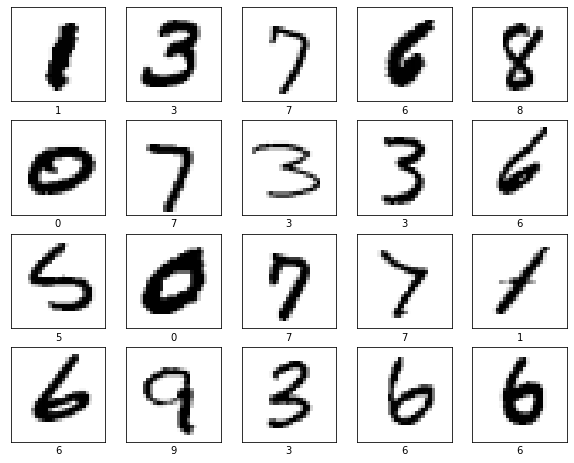

In [2]:
from simple_deep_learning.mnist_extended.mnist import display_digits

display_digits(images=train_images, labels=train_labels, num_to_display=20)

These digits form the base of MNIST extended. Let's see how we can turn those single digit images into a semantic segmentation dataset.

## Semantic segmentation

Semantic segmentation is the task of assigning a label to each pixel of an image.
It can be seen as a an image classification task, except that instead of classifying the whole image, you're classifying each pixel individually.

The input image is created by randomly overlaying digits from the original MNIST dataset on an empty array. The target array is of shape (height, width, num_classes), this corresponds to an output for which each pixel has a class.

Let's take a look at what this might look like. We'll generate images of height and width 60 pixels and choose digits 0-4 (i.e num_classes = 5).
We're just going to use the basic parameters of the create_semantic_segmentation_dataset function. For more customisation, take a look at the documented code or check the "Customisation" section at the end of the article.

In [3]:
import numpy as np
np.random.seed(seed=9)

from simple_deep_learning.mnist_extended.semantic_segmentation import (create_semantic_segmentation_dataset, display_segmented_image,
                                                                       display_grayscale_array, plot_class_masks)

train_x, train_y, test_x, test_y = create_semantic_segmentation_dataset(num_train_samples=100,
                                                                        num_test_samples=10,
                                                                        image_shape=(60, 60),
                                                                        num_classes=5)

Below is a randomly selected example from the dataset and its shape. As you can see, the input is of shape (height, width, 1) which is expected, the input is a simple grayscale image. The output is of shape (height, width, num_classes), there is one channel per class. We'll see what each channel contains in a bit.

In [4]:
import numpy as np

i = np.random.randint(len(train_x))
print(train_x[i].shape)
print(train_y[i].shape)

(60, 60, 1)
(60, 60, 5)


The following code displays the input image, as already mentioned, this is simply the original digits of MNIST randomly overlaid on a blank canvas.

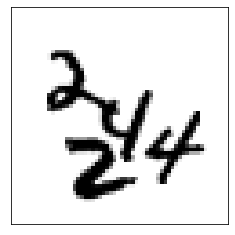

In [5]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_grayscale_array

i = np.random.randint(len(train_x))
display_grayscale_array(array=train_x[i])

The target class is a lot more interesting. The target array has a 3rd dimension of length equal to the number of classes to predict. That is, if our input images are composed of MNIST digits 0-4, then our target array will have a shape (width, height, 5).

In the following cell, we have a function that indexes the target array along the third axis (the classes axis) and displays each slice individually. 

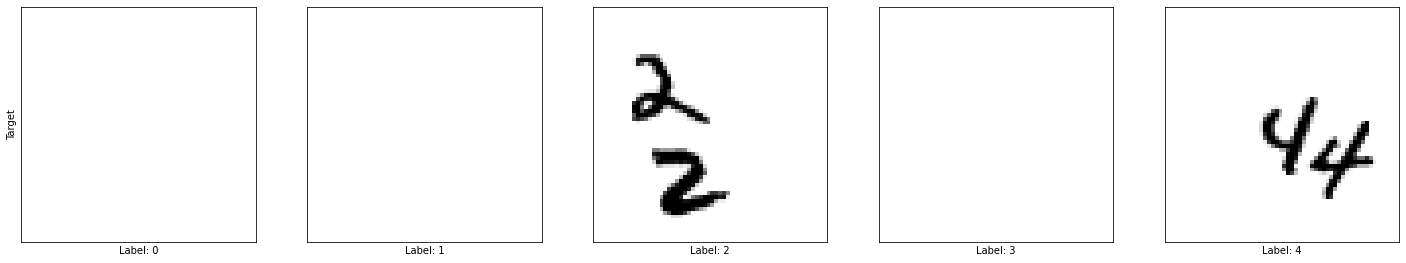

In [6]:
from simple_deep_learning.mnist_extended.semantic_segmentation import plot_class_masks
plot_class_masks(train_y[i])

Each slice contains only one type of digit. In our case, the input image is composed of 2 twos and 2 fours, therefore the target array has 2 twos at slice 2 and 2 fours at slice 4.

It's by separating the digits of a certain class into different slices that we tell our model which pixels correspond to which class. When training a model, we want it to be able to separate pixels of the original image into their respective slice.

By default, in our dataset, classes are not exclusive. That means a pixel can part of more than one digit at a time. This will affect our loss function when building models but is not particularly important. If you want exclusive classes, you can set labels_are_exclusive=True in the create_semantic_segmentation_dataset function, in which case for pixels from multiple digits will only have one class, selected at random.

Below is another way of displaying the digits. This time instead of separating the slices, we give each slice a particular colour. Here's what that looks like:

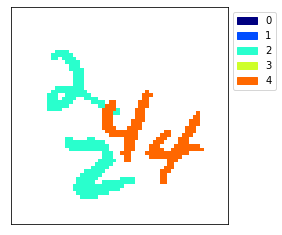

In [7]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_grayscale_array
display_segmented_image(y=train_y[i])

That's it for the basic information on the semantic segmentation dataset. If you want an example of how this dataset is used to train a neural network for image segmentation, checkout my tutorial: [A simple example of semantic segmentation with tensorflow keras](https://awaywithideas.com/a-simple-example-of-semantic-segmentation-with-tensorflow-keras/)

## Object detection

Object detection is the task of drawing a bounding box around objects of interest. The input data for the object detection problem is exactly the same as for the semantic segmentation. The target however is different. Instead of classifying each pixel, we want to output the coordinates of a bounding box and a class label for each predicted bounding box.

Generating the target for an object detection task is more complicated than for semantic segmentation. Different models use different target arrays. To remain generic, I have decided to output the bounding boxes and labels as lists. This cannot be used directly as a target for machine learning models but can be processed to produce a suitable target array for a given model.

In [8]:
from simple_deep_learning.mnist_extended.object_detection import create_object_detection_dataset    

train_x, train_bounding_boxes, train_labels, test_x, test_bounding_boxes, test_labels = create_object_detection_dataset(
    num_train_samples=100, num_test_samples=10, image_shape=(60, 60))


The input array (i.e x) is in the same format as for semantic segmentation.

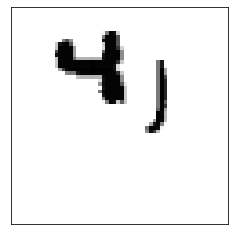

In [9]:
from simple_deep_learning.mnist_extended.semantic_segmentation import display_grayscale_array

i = np.random.randint(len(train_x))
display_grayscale_array(array=train_x[i])

Let's take a look at the bounding boxes and labels.

In [10]:
print(train_bounding_boxes[i])
print(train_labels[i])

[[ 9  2 37 30]
 [27 11 55 39]]
[4 1]


We see the (xmin, ymin, xmax, ymax) coordinates of each bounding box, as well as the associated label. As mentioned before, this cannot directly be used as a target because different images have a different number of bounding boxes and the output of most neural networks (e.g excluding RNNs) is of fixed size for an input of a given size. For anyone interested in how to construct the target for an object detection model, I recommend checking the architecture of single shot detection (SSD) models. They are very commonly used models for object detection and relatively simple.

I have created a function to draw the bounding boxes on the array and return a PIL image.

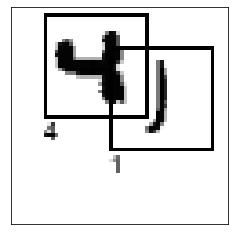

In [11]:
from simple_deep_learning.mnist_extended.object_detection import draw_bounding_boxes

a = np.array(draw_bounding_boxes(train_x[i], bounding_boxes=train_bounding_boxes[i], labels=train_labels[i]))
display_grayscale_array(a)

## Customisation

So far we've only used the main parameters of the create dataset functions. I recommend checking the code to find how to change things such as the maximum number of digits per image, the maximum IOU (intersection of union) of two digits in the same image and more.

In this post, we've been using the end to end functions create_semantic_segmentation_dataset and create_object_detection_dataset.

These perform the following tasks:
- Download the original MNIST dataset.
- Preprocess the original MNIST images.
- Overlay the MNIST digits to create the new input image.
- Create the target/output arrays.

These components are all part of the MNIST extended package and are very modular. This provides you with a lot of freedom to customise the dataset as you would like. For instance, if you want to perform additional preprocessing on the original MNIST digits, that's totally possible. You might want modify the digits by randomly changing their size, in which case you can use the [individual functions](https://github.com/LukeTonin/simple-deep-learning/blob/main/simple_deep_learning/mnist_extended/mnist.py) for downloading and preprocessing the MNIST digits. Then you can add a function to modify their size and finally feed the modified images and labels into the [create_object_detection_data_from_digits](https://github.com/LukeTonin/simple-deep-learning/blob/main/simple_deep_learning/mnist_extended/object_detection.py) or [create_semantic_segmentation_data_from_digits](https://github.com/LukeTonin/simple-deep-learning/blob/main/simple_deep_learning/mnist_extended/semantic_segmentation.py).

I hope you have a lot of fun playing around with this dataset. I've certainly found it very useful for experimenting with model architectures and learning about deep learning more generally. I would love to hear what you've done with the dataset so please post a comment below or send me a message via LinkedIn!

Have a great day.

Luke

In [13]:
!jupyter nbconvert --to markdown mnist_extended.ipynb

[NbConvertApp] Converting notebook mnist_extended.ipynb to markdown
[NbConvertApp] Support files will be in mnist_extended_files/
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Making directory mnist_extended_files
[NbConvertApp] Writing 12478 bytes to mnist_extended.md
